# Load Data & Feature Selection

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
import datetime as dt
import warnings

warnings.simplefilter("ignore")

In [5]:
df = pd.read_csv('wildfire.csv')
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,...,A,40.036944,-121.005833,5,USFS,CA,63,63.0,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.933056,-120.404444,5,USFS,CA,61,61.0,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.984167,-120.735556,13,STATE OR PRIVATE,CA,17,17.0,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.913333,5,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.933056,5,USFS,CA,3,3.0,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [6]:
#only include the five states
df_clean=df.loc[df['STATE'].isin(['CA','AL','TX','NM','NV'])]

#select the useful columns and create feature "MONTH" using DISCOVER_DOY
cols = ['NWCG_REPORTING_UNIT_NAME','FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STAT_CAUSE_DESCR','FIRE_SIZE_CLASS','STATE']
fire = df_clean[cols]
fire['discover_date'] =  pd.to_datetime(fire['FIRE_YEAR']) + (fire['DISCOVERY_DOY'] - 1).map(dt.timedelta)
fire['MONTH'] = pd.DatetimeIndex(fire['discover_date']).month
fire = fire.drop(columns=['FIRE_YEAR', 'DISCOVERY_DOY', 'discover_date']).reset_index().drop(columns = 'index')
fire.head()

,NWCG_REPORTING_UNIT_NAME,LATITUDE,LONGITUDE,OWNER_DESCR,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,MONTH
0,Plumas National Forest,40.036944,-121.005833,USFS,Miscellaneous,A,CA,2
1,Eldorado National Forest,38.933056,-120.404444,USFS,Lightning,A,CA,5
2,Eldorado National Forest,38.984167,-120.735556,STATE OR PRIVATE,Debris Burning,A,CA,6
3,Eldorado National Forest,38.559167,-119.913333,USFS,Lightning,A,CA,6
4,Eldorado National Forest,38.559167,-119.933056,USFS,Lightning,A,CA,6


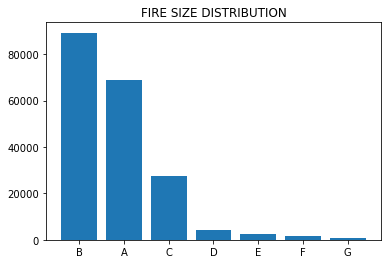

In [7]:
#imbalanced data
plt.bar(fire['FIRE_SIZE_CLASS'].value_counts().index, fire['FIRE_SIZE_CLASS'].value_counts())
plt.title('FIRE SIZE DISTRIBUTION')
plt.show()

In [8]:
#NWCG_REPORTING_UNIT_NAME is correlated with the LATITUDE and LONGITUDE, we get rid of it.
fire = fire.drop(columns = 'NWCG_REPORTING_UNIT_NAME')
fire.head()

,LATITUDE,LONGITUDE,OWNER_DESCR,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,MONTH
0,40.036944,-121.005833,USFS,Miscellaneous,A,CA,2
1,38.933056,-120.404444,USFS,Lightning,A,CA,5
2,38.984167,-120.735556,STATE OR PRIVATE,Debris Burning,A,CA,6
3,38.559167,-119.913333,USFS,Lightning,A,CA,6
4,38.559167,-119.933056,USFS,Lightning,A,CA,6


In [9]:
#check missing values
fire.isna().sum()

LATITUDE            0
LONGITUDE           0
OWNER_DESCR         0
STAT_CAUSE_DESCR    0
FIRE_SIZE_CLASS     0
STATE               0
MONTH               0
dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
fire["FIRE_SIZE_CLASS"] = le.fit_transform(fire["FIRE_SIZE_CLASS"])
fire.head()

,LATITUDE,LONGITUDE,OWNER_DESCR,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,MONTH
0,40.036944,-121.005833,USFS,Miscellaneous,0,CA,2
1,38.933056,-120.404444,USFS,Lightning,0,CA,5
2,38.984167,-120.735556,STATE OR PRIVATE,Debris Burning,0,CA,6
3,38.559167,-119.913333,USFS,Lightning,0,CA,6
4,38.559167,-119.933056,USFS,Lightning,0,CA,6


In [11]:
#importing the external feature: elevation
fire_sample=pd.read_pickle('fire.pkl')
fire_data = pd.concat([fire, fire_sample['elevation']], axis=1)
fire_data = fire_data.rename(columns = {'elevation': 'ELEVATION'})
fire_data['ELEVATION'] = fire_data['ELEVATION'].astype(float)
fire_data['MONTH'] = fire_data['MONTH'].astype(str)
fire_data.head()

,LATITUDE,LONGITUDE,OWNER_DESCR,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,MONTH,ELEVATION
0,40.036944,-121.005833,USFS,Miscellaneous,0,CA,2,924.73
1,38.933056,-120.404444,USFS,Lightning,0,CA,5,1831.26
2,38.984167,-120.735556,STATE OR PRIVATE,Debris Burning,0,CA,6,1048.65
3,38.559167,-119.913333,USFS,Lightning,0,CA,6,2361.86
4,38.559167,-119.933056,USFS,Lightning,0,CA,6,2309.84


In [12]:
#Feature selection using mutual information and forward stepwise selection 

In [13]:
fire_feature = {}
for col in ['OWNER_DESCR', 'STAT_CAUSE_DESCR', 'STATE']:
    fire_feature[col] = le.fit_transform(fire_data[col])
feature_df = pd.DataFrame(fire_feature)
feature_df = pd.concat([feature_df, fire_data[['LATITUDE', 'LONGITUDE', 'MONTH', 'ELEVATION']]], axis=1)
feature_df.head()

,OWNER_DESCR,STAT_CAUSE_DESCR,STATE,LATITUDE,LONGITUDE,MONTH,ELEVATION
0,12,7,1,40.036944,-121.005833,2,924.73
1,12,6,1,38.933056,-120.404444,5,1831.26
2,10,3,1,38.984167,-120.735556,6,1048.65
3,12,6,1,38.559167,-119.913333,6,2361.86
4,12,6,1,38.559167,-119.933056,6,2309.84


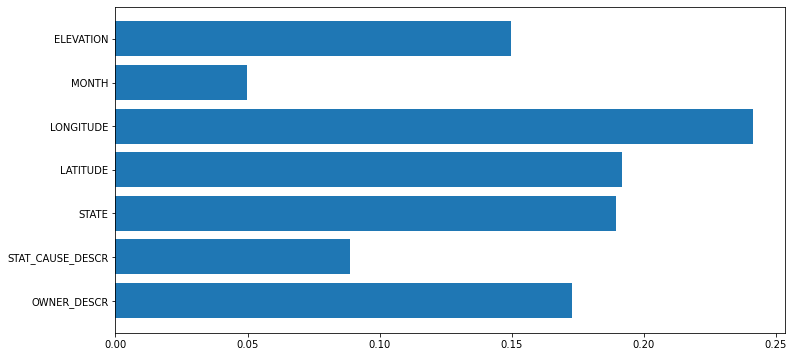

In [14]:
#visualize the mutual information between feature and target
plt.figure(figsize=(12, 6))
plt.barh(feature_df.columns, mutual_info_classif(feature_df, fire['FIRE_SIZE_CLASS']))
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(fire_data.drop(columns = 'FIRE_SIZE_CLASS'), fire_data['FIRE_SIZE_CLASS'], test_size=0.2, random_state=42)

#20% of the training set is for validation purpose
val_idx = int(0.8*len(X_train))
X_train, X_val = X_train[:val_idx], X_train[val_idx:]
y_train, y_val = y_train[:val_idx], y_train[val_idx:]

In [ ]:
#forward stepwise selection using two baseline models: RandomForest and LogisticRegression (check the non-linearity in data)
sorted_features = ['LONGITUDE', 'LATITUDE', 'STATE', 'OWNER_DESCR', 'ELEVATION', 'STAT_CAUSE_DESCR', 'MONTH']
feature_set = []
accuracy_rf, accuracy_lr = [], []

for i in sorted_features:
    feature_set.append(i)
    x_train, x_val = X_train[feature_set], X_val[feature_set]
    x_train, x_val = pd.get_dummies(x_train, drop_first=True), pd.get_dummies(x_val, drop_first=True)

    #train a random forest model
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf.fit(x_train, y_train)
    y_rf = rf.predict(x_val)
    acc_rf = accuracy_score(y_val, y_rf)
    accuracy_rf.append(acc_rf)
    print("feature set: {} ---- Random Forest Accuracy: {}".format(feature_set, acc_rf))

    #train a logistic regression model
    lr = LogisticRegression(class_weight='balanced', random_state=42)
    lr.fit(x_train, y_train)
    y_lr = lr.predict(x_val)
    acc_lr = accuracy_score(y_val, y_lr)
    accuracy_lr.append(acc_lr)
    print("feature set: {} ---- Logistic Regression Accuracy: {}".format(feature_set, acc_lr))

feature set: ['LONGITUDE'] ---- Random Forest Accuracy: 0.4711445976274447
feature set: ['LONGITUDE'] ---- Logistic Regression Accuracy: 0.3643154857326066
feature set: ['LONGITUDE', 'LATITUDE'] ---- Random Forest Accuracy: 0.5910548252645078
feature set: ['LONGITUDE', 'LATITUDE'] ---- Logistic Regression Accuracy: 0.2709201667201026
feature set: ['LONGITUDE', 'LATITUDE', 'STATE'] ---- Random Forest Accuracy: 0.5894838089131131
feature set: ['LONGITUDE', 'LATITUDE', 'STATE'] ---- Logistic Regression Accuracy: 0.3257774927861494
feature set: ['LONGITUDE', 'LATITUDE', 'STATE', 'OWNER_DESCR'] ---- Random Forest Accuracy: 0.5920807951266431
feature set: ['LONGITUDE', 'LATITUDE', 'STATE', 'OWNER_DESCR'] ---- Logistic Regression Accuracy: 0.3789996793844181
feature set: ['LONGITUDE', 'LATITUDE', 'STATE', 'OWNER_DESCR', 'ELEVATION'] ---- Random Forest Accuracy: 0.6005450464892593
feature set: ['LONGITUDE', 'LATITUDE', 'STATE', 'OWNER_DESCR', 'ELEVATION'] ---- Logistic Regression Accuracy: 0.2

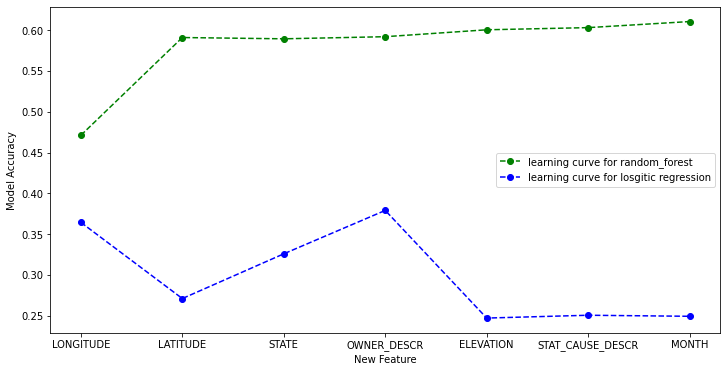

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(accuracy_rf, 'go--', label='learning curve for random_forest')
plt.plot(accuracy_lr, 'bo--', label='learning curve for losgitic regression')
plt.title('forward stepwise selection')
plt.xlabel('New Feature')
plt.ylabel('Model Accuracy')
plt.xticks(np.arange(7), sorted_features)
plt.legend()
plt.show()

From the above plot, we can see that logistic regression performs poorly, so our data has a lot of non-linearity.

Longitude and Latitude are the two main factors for predicting the fire size.

Although state has the third largest MI with the target variable, it does not improve our model's performance at all because its information is included in the laitude and longitude. So we can remove it from our feature set. 

All the other features provide marginal boost to our model's performance, so we decide to remain them in our feature set.

In [16]:
#final feature set
final_feature = ['LONGITUDE', 'LATITUDE', 'OWNER_DESCR', 'ELEVATION', 'STAT_CAUSE_DESCR', 'MONTH']

X, y = fire_data[final_feature], fire_data['FIRE_SIZE_CLASS']
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
#model selection (rf, xgb, knn, svm)
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier


kf = KFold(5)

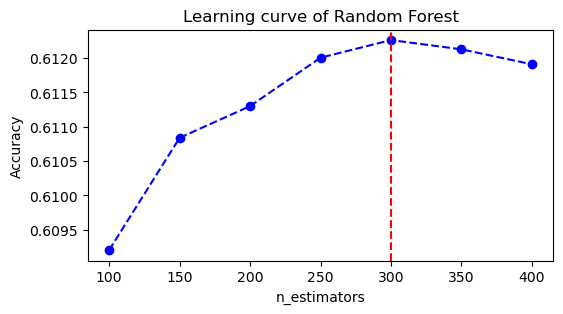

In [37]:
#random forest hyperparameter tuning using oob score
n_est = [100, 150, 200, 250, 300, 350, 400]
val_acc = []
for i in n_est:
    rf = RandomForestClassifier(n_estimators=i, oob_score=True, class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    val_acc.append(rf.oob_score_)

rf_training_acc = {i:acc for i, acc in zip(n_est, val_acc)}
f = open("rf_train.pkl", "wb")
pkl.dump(rf_training_acc, f)
f.close()

plt.style.use('default')

fig = plt.figure(figsize=(6, 3))
f = open("rf_train.pkl", "rb")
rf_acc = pkl.load(f)

plt.plot([val for key, val in rf_acc.items()], 'bo--')
plt.title("Learning curve of Random Forest")
plt.xlabel('n_estimators')
plt.xticks(np.arange(len(nn_acc)), [key for key, val in rf_acc.items()])
plt.axvline(x=4, linestyle='--', color='r')
plt.ylabel("Accuracy")
plt.show()

plt.style.use('default')

fig = plt.figure(figsize=(6, 3))
f = open("rf_train.pkl", "rb")
rf_acc = pkl.load(f)

plt.plot([val for key, val in rf_acc.items()], 'bo--')
plt.title("Learning curve of Random Forest")
plt.xlabel('n_estimators')
plt.xticks(np.arange(len(nn_acc)), [key for key, val in rf_acc.items()])
plt.axvline(x=4, linestyle='--', color='r')
plt.ylabel("Accuracy")
plt.show()

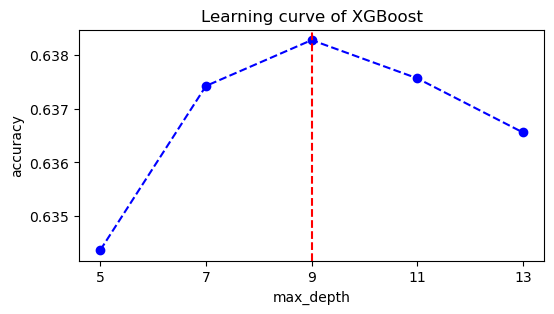

In [38]:
#XGBoost hyperparameter tuning (max_depth)
depth = [5, 7, 9, 11, 13]
val_acc = []

for j in depth:
    cv_acc = []
    for train_index, val_index in kf.split(X_train):
        train_kf, val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
        y_kf, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        xgb_model = xgb.XGBClassifier(objective='multi:softprob', n_estimators=200, max_depth=j, random_state=42)
        xgb_model.fit(train_kf, y_kf)
        y_hat = xgb_model.predict(val_kf)
        acc = accuracy_score(y_hat, y_val)
        cv_acc.append(acc)
        
    avg_acc = np.mean(cv_acc)
    val_acc.append(avg_acc)

xgb_training_acc = {i:acc for i, acc in zip(depth, val_acc)}
f = open("xgb_train.pkl", "wb")
pkl.dump(xgb_training_acc, f)
f.close()

f = open("xgb_train.pkl", "rb")
xgb_acc = pkl.load(f)

plt.figure(figsize=(6, 3))
plt.plot([val for key, val in xgb_acc.items()], 'bo--')
plt.title("Learning curve of XGBoost")
plt.xlabel("max_depth")
plt.xticks(np.arange(len(xgb_acc)), [key for key, val in xgb_acc.items()])
plt.ylabel("accuracy")
plt.axvline(x=2, linestyle='--', color='r')
plt.show()

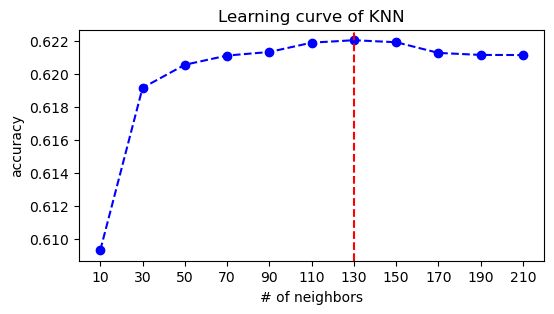

In [40]:
k = np.arange(10, 220, 20)
val_acc = []

for i in k:
        cv_acc = []
        for train_index, val_index in kf.split(X_train):
            train_kf, val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
            y_kf, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

            knn = KNeighborsClassifier(n_neighbors=i)
            knn.fit(train_kf, y_kf)
            y_hat = knn.predict(val_kf)
            acc = accuracy_score(y_hat, y_val)
            cv_acc.append(acc)
        avg_acc = np.mean(cv_acc)
        #print("neighbors: {}, kfold average accuracy: {}".format(i, avg_acc))
        val_acc.append(avg_acc)

knn_training_acc = {i:acc for i, acc in zip(k, val_acc)}
f = open("knn_train.pkl", "wb")
pkl.dump(knn_training_acc, f)
f.close()

f = open("knn_train.pkl", "rb")
knn_acc = pkl.load(f)

plt.figure(figsize=(6, 3))
plt.plot([val for key, val in knn_acc.items()], 'bo--')
plt.title("Learning curve of KNN")
plt.xlabel("# of neighbors")
plt.xticks(np.arange(11), [key for key, val in knn_acc.items()])
plt.ylabel("accuracy")
plt.axvline(x=6, linestyle='--', color='r')
plt.show()

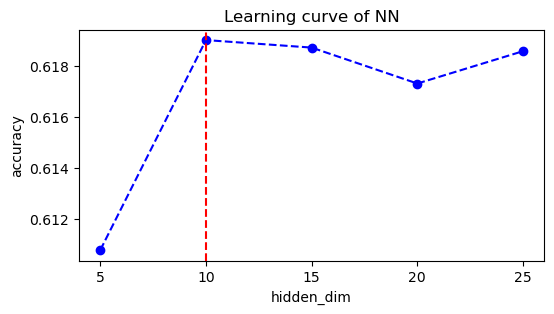

In [43]:
hidden_dim = [5, 10, 15, 20, 25]
val_acc = []
kf = KFold(5)

for i in hidden_dim:
    cv_acc = []
    for train_index, val_index in kf.split(X_train):
        train_kf, val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
        y_kf, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        nn = MLPClassifier(solver='adam', 
                           hidden_layer_sizes=i, 
                           early_stopping = True,
                           validation_fraction = 0.1,
                           random_state=42)
        nn.fit(train_kf, y_kf)
        y_hat = nn.predict(val_kf)
        acc = accuracy_score(y_hat, y_val)
        cv_acc.append(acc)
    avg_acc = np.mean(cv_acc)
    val_acc.append(avg_acc)

nn_training_acc = {i:acc for i, acc in zip(hidden_dim, val_acc)}
f = open("nn_train.pkl", "wb")
pkl.dump(nn_training_acc, f)
f.close()

f = open("nn_train.pkl", "rb")
nn_acc = pkl.load(f)

plt.figure(figsize=(6, 3))
plt.plot([val for key, val in nn_acc.items()], 'bo--')
plt.title("Learning curve of NN")
plt.xlabel('hidden_dim')
plt.xticks(np.arange(len(nn_acc)), [key for key, val in nn_acc.items()])
plt.ylabel("accuracy")
plt.axvline(x=1, linestyle='--', color='r')
plt.show()

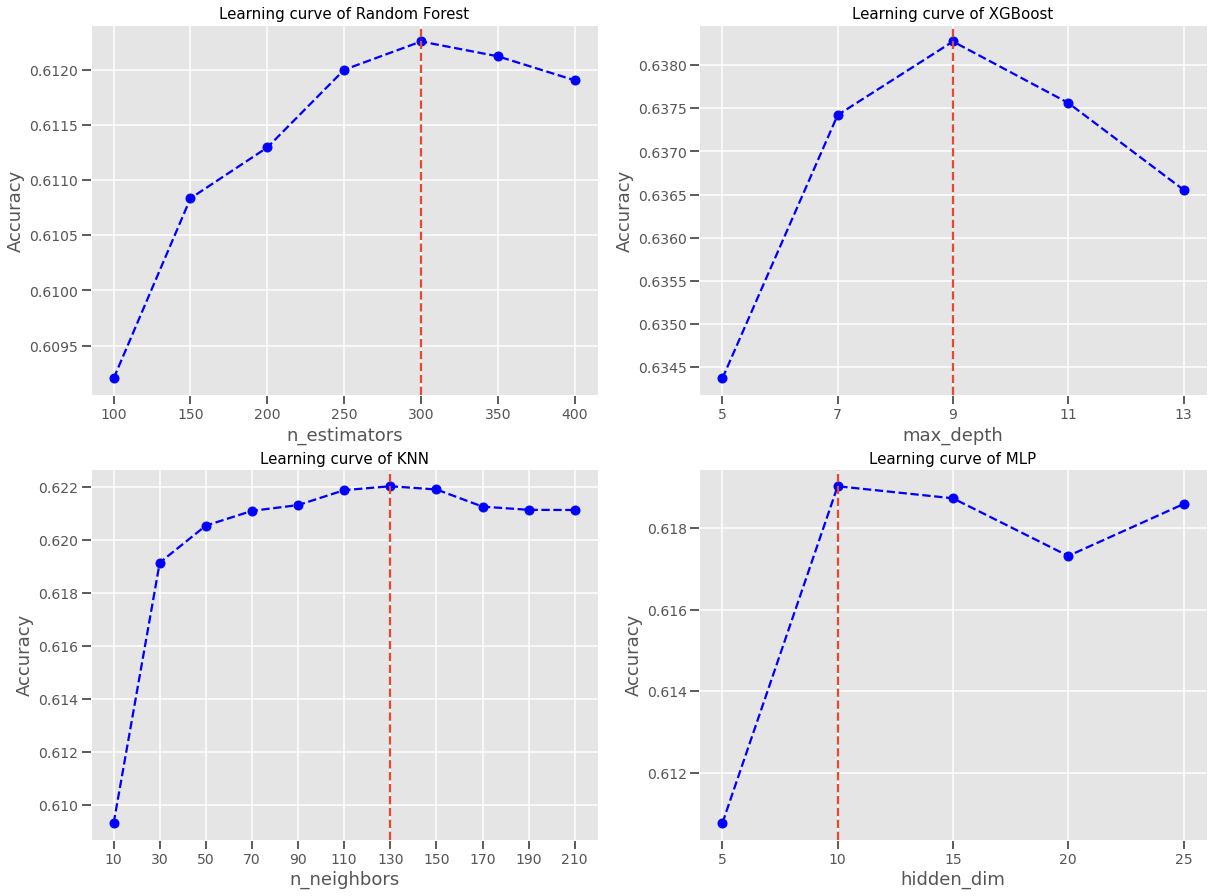

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np

sns.set_context("talk")
plt.style.use('ggplot')

plt.rc('font', **font)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=15)
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

f = open("rf_train.pkl", "rb")
nn_acc = pkl.load(f)

axes[0,0].plot([val for key, val in nn_acc.items()], 'bo--')
axes[0,0].set_title("Learning curve of Random Forest")
axes[0,0].set_xlabel('n_estimators')
axes[0,0].set_xticks(np.arange(len(nn_acc)))
axes[0,0].set_xticklabels([key for key, val in nn_acc.items()])
axes[0,0].axvline(x=4, linestyle='--')
axes[0,0].set_ylabel("Accuracy")


f = open("xgb_train.pkl", "rb")
nn_acc = pkl.load(f)

axes[0,1].plot([val for key, val in nn_acc.items()], 'bo--')
axes[0,1].set_title("Learning curve of XGBoost")
axes[0,1].set_xlabel('max_depth')
axes[0,1].set_xticks(np.arange(len(nn_acc)))
axes[0,1].set_xticklabels([key for key, val in nn_acc.items()])
axes[0,1].axvline(x=2, linestyle='--')
axes[0,1].set_ylabel("Accuracy")


f = open("knn_train.pkl", "rb")
nn_acc = pkl.load(f)

axes[1,0].plot([val for key, val in nn_acc.items()], 'bo--')
axes[1,0].set_title("Learning curve of KNN")
axes[1,0].set_xlabel('n_neighbors')
axes[1,0].set_xticks(np.arange(len(nn_acc)))
axes[1,0].set_xticklabels([key for key, val in nn_acc.items()])
axes[1,0].axvline(x=6, linestyle='--')
axes[1,0].set_ylabel("Accuracy")


f = open("nn_train.pkl", "rb")
nn_acc = pkl.load(f)

axes[1,1].plot([val for key, val in nn_acc.items()], 'bo--')
axes[1,1].set_title("Learning curve of MLP")
axes[1,1].set_xlabel('hidden_dim')
axes[1,1].set_xticks(np.arange(len(nn_acc)))
axes[1,1].set_xticklabels([key for key, val in nn_acc.items()])
axes[1,1].axvline(x=1, linestyle='--')
axes[1,1].set_ylabel("Accuracy")
plt.savefig('books_read.png')
plt.show()


In [46]:
rng = 42

estimators = [
    ('rf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state = rng)),
    ('MLP', MLPClassifier(solver='adam', 
                          hidden_layer_sizes=10, 
                          early_stopping = True,
                          validation_fraction = 0.1,
                          random_state = rng)), 
    ('xgb', xgb.XGBClassifier(objective='multi:softmax', n_estimators=200, max_depth=9, random_state = rng)),
    ('knn', KNeighborsClassifier(n_neighbors=130))
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=xgb.XGBClassifier(objective='multi:softmax', n_estimators=150, max_depth=3, random_state = rng)
)

cv_acc = []
for train_index, val_index in kf.split(X_train):
        train_kf, val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
        y_kf, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        clf2.fit(train_kf, y_kf)
        y_hat = clf2.predict(val_kf)
        acc = accuracy_score(y_hat, y_val)
        cv_acc.append(acc)
        
avg_acc = np.mean(cv_acc)

clf.fit(X_train, y_train)

f = open("ensemble_LR_model.pkl", "wb")
pkl.dump(clf, f)
f.close()

In [47]:
f = open("ensemble_LR_model.pkl", "rb")
clf = pkl.load(f)

y_hat = clf.predict(X_test)
train_pred = clf.predict_proba(X_train)
test_pred = clf.predict_proba(X_test)

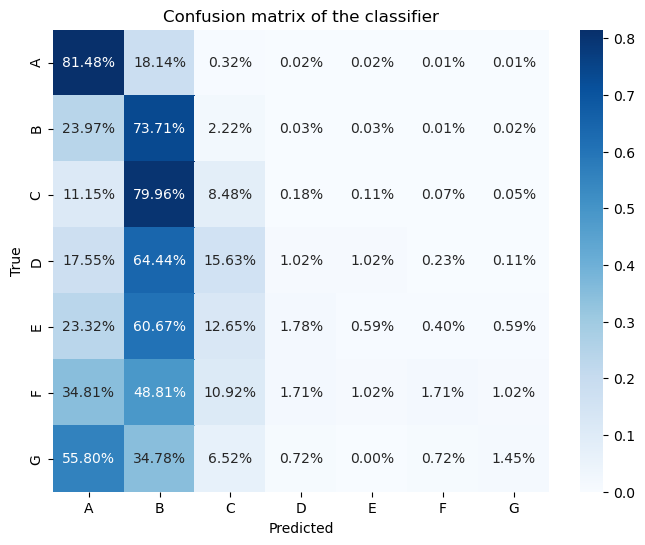

In [52]:
labels = [0, 1, 2, 3, 4, 5, 6]
cm = confusion_matrix(y_test, y_hat, labels, normalize='true')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=ax)
plt.title('Confusion matrix of the classifier')
ax.set_xticks(np.arange(len(labels))+0.5)
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
ax.set_yticks(np.arange(len(labels))+0.5)
ax.set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [49]:
def classifier(y_pred, y_train, final_pred):
    train_label = y_train.reset_index().drop(columns = 'index')
    result = np.empty(final_pred.shape[0])

    lt_6 = train_label.loc[train_label['FIRE_SIZE_CLASS'] < 6].index
    threshold_6 = np.quantile(np.log(y_pred[lt_6, 6]), 0.995)

    lt_5 = train_label.loc[train_label['FIRE_SIZE_CLASS'] < 5].index
    threshold_5 = np.quantile(np.log(y_pred[lt_5, 5]), 0.995)

    lt_4 = train_label.loc[train_label['FIRE_SIZE_CLASS'] < 4].index
    threshold_4 = np.quantile(np.log(y_pred[lt_4, 4]), 0.99)

    lt_3 = train_label.loc[train_label['FIRE_SIZE_CLASS'] < 3].index
    threshold_3 = np.quantile(np.log(y_pred[lt_3, 3]), 0.98)

    lt_2 = train_label.loc[train_label['FIRE_SIZE_CLASS'] < 2].index
    threshold_2 = np.quantile(np.log(y_pred[lt_2, 2]), 0.98)
    
    for i, pred in enumerate(np.log(final_pred)):
        if pred[6] >= threshold_6:
            result[i] = 6
        elif pred[5] >= threshold_5:
            result[i] = 5
        elif pred[4] >= threshold_4:
            result[i] = 4
        elif pred[3] >= threshold_3:
            result[i] = 3
        elif pred[2] >= threshold_2:
            result[i] = 2
        else:
            if pred[1]>pred[0]:
                result[i] = 1
            else:
                result[i] = 0
    
    return result

In [50]:
final_pred = classifier(train_pred, y_train, test_pred)

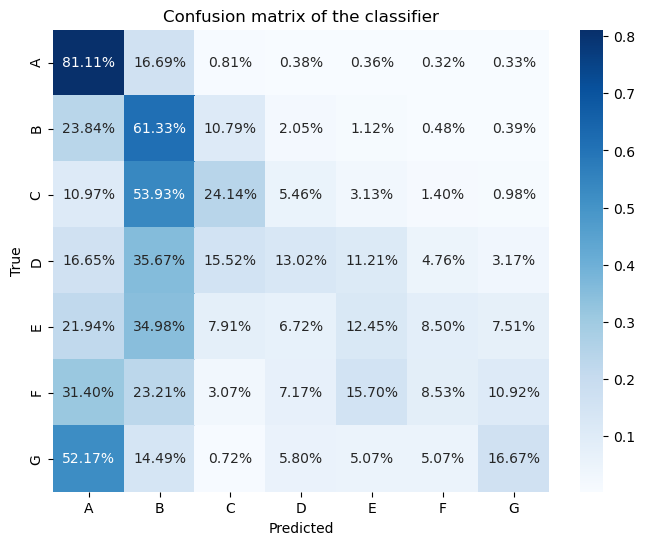

In [53]:
labels = [0, 1, 2, 3, 4, 5, 6]
cm = confusion_matrix(y_test, final_pred, labels, normalize='true')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=ax)
plt.title('Confusion matrix of the classifier')
ax.set_xticks(np.arange(len(labels))+0.5)
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
ax.set_yticks(np.arange(len(labels))+0.5)
ax.set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()